# Disability at six month follow up

## Aims

Data on disability at six month follow up is not missing at random.

Investigating factors that relate to:
* Whether patients have a record of disability at six months
* Patients disability score/change in disability between discharge and follow up

This analysis has been repeated using the whole dataset (only filtered by number of admissions at hospital per year) as will as the filtered dataset (only patients who arrived within four hours of known stroke onset).

## Set up

In [1]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path,
                                paths.data_filename))
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Descriptive

### Completion

Below are summaries of completion for all patients, and for patients who arrive within four hours of known onset.

In [4]:
def count_missing(df):
    '''
    Find count and proportion of people missing disability at each timepoint
    '''
    # Mark whether disability is present at each timepoint or not
    mrs_missing = (
        df[['prior_disability',
            'discharge_disability',
            'disability_6_month']]
        .isnull()
        .apply(lambda x: x.map({True: 'Missing', False: 'Not missing'})))

    # Count patterns of missing or not between variables
    mrs_complete = (
        mrs_missing
        .value_counts()
        .reset_index(name='count')
        .sort_values(by='disability_6_month', ascending=False))

    # Convert counts to proportions
    mrs_complete['percentage'] = (
        mrs_complete['count'] / mrs_complete['count'].sum())*100
    display(mrs_complete)

    return (mrs_missing)


print('For all patients...')
mrs_missing_data_full = count_missing(data_full)
print('For patients who arrive within four hours of known onset...')
mrs_missing_data = count_missing(data)

For all patients...


,prior_disability,discharge_disability,disability_6_month,count,percentage
1,Not missing,Not missing,Not missing,109321,30.461375
0,Not missing,Not missing,Missing,247034,68.833941
2,Not missing,Missing,Missing,2529,0.704685


For patients who arrive within four hours of known onset...


,prior_disability,discharge_disability,disability_6_month,count,percentage
1,Not missing,Not missing,Not missing,39167,28.585087
0,Not missing,Not missing,Missing,96845,70.679979
2,Not missing,Missing,Missing,1007,0.734935


As we would anticipate, no-one marked as having died (which we understand to mean they were not discharged following arrival as they died), has a 6-month follow-up. Hence, summaries of completion are repeated, but for individuals who were alive...

In [5]:
def disability_known_death(df):
    # Add column indicating whether disability at 6 months was known
    df['disability_6_month_known'] = (
        df['disability_6_month']
        .isnull()
        .map({True: 'No (missing)', False: 'Yes (present)'}))
    # View relationship between death and 6 month follow up
    display(df
            .groupby('disability_6_month_known')['death']
            .value_counts(dropna=False)
            .reset_index(name='count'))
    return (df)


print('For all patients...')
data = disability_known_death(data)
print('For patients who arrive within four hours of known onset...')
data_full = disability_known_death(data_full)

For all patients...


,disability_6_month_known,death,count
0,No (missing),0.0,74322
1,No (missing),1.0,23526
2,No (missing),NaN,4
3,Yes (present),0.0,39167


For patients who arrive within four hours of known onset...


,disability_6_month_known,death,count
0,No (missing),0.0,199725
1,No (missing),1.0,49828
2,No (missing),NaN,10
3,Yes (present),0.0,109321


In [6]:
def count_alive_missing(df, mrs_missing):
    '''
    Find count and proportion of people missing disability at each timepoint
    Focussing only on individuals who were alive at discharge
    '''
    # Add death
    mrs_missing['death'] = df['death']

    # Count proportion missing data
    mrs_complete_alive = (
        mrs_missing[mrs_missing['death'] == 0]
        .value_counts()
        .reset_index(name='count')
        .sort_values(by='disability_6_month', ascending=False))
    mrs_complete_alive['percentage'] = (
        mrs_complete_alive['count'] / mrs_complete_alive['count'].sum())*100

    return (mrs_complete_alive)


print('For all patients...')
display(count_alive_missing(data_full, mrs_missing_data_full))
print('For patients who arrive within four hours of known onset...')
display(count_alive_missing(data, mrs_missing_data))

For all patients...


,prior_disability,discharge_disability,disability_6_month,death,count,percentage
1,Not missing,Not missing,Not missing,0.0,109321,35.373698
0,Not missing,Not missing,Missing,0.0,197208,63.811860
2,Not missing,Missing,Missing,0.0,2517,0.814442


For patients who arrive within four hours of known onset...


,prior_disability,discharge_disability,disability_6_month,death,count,percentage
1,Not missing,Not missing,Not missing,0.0,39167,34.511715
0,Not missing,Not missing,Missing,0.0,73320,64.605380
2,Not missing,Missing,Missing,0.0,1002,0.882905


### Filter to alive at discharge

In [7]:
# All patients
data_full_alive = data_full[data_full['death'] == 0]
# Patients who arrive within four hours of known onset
data_alive = data[data['death'] == 0]

### Comparing patients followed up with those not

Of those who were alive at discharge, can compare average stroke severity between those followed up and not, and whether a higher proportion of thrombolysed patients have a 6-month-follow-up than non-thrombolysed.

In [8]:
def compare_follow_up(df):
    # Stroke severity
    display(df
            .groupby('disability_6_month_known')['stroke_severity']
            .describe())

    # Thrombolysis
    display(df
            .groupby('thrombolysis')['disability_6_month_known']
            .value_counts(normalize=True)
            .reset_index(name='proportion'))


print('For all patients alive at discharge:')
compare_follow_up(data_full_alive)
print('For patients alive at discharge who had arrived within 4h known onset:')
compare_follow_up(data_alive)

For all patients alive at discharge:


,count,mean,std,min,25%,50%,75%,max
disability_6_month_known,,,,,,,,
No (missing),199725.0,5.511238,5.949742,0.0,2.0,3.0,7.0,42.0
Yes (present),109321.0,5.370002,5.683979,0.0,2.0,3.0,7.0,42.0


,thrombolysis,disability_6_month_known,proportion
0,0,No (missing),0.647322
1,0,Yes (present),0.352678
2,1,No (missing),0.638126
3,1,Yes (present),0.361874


For patients alive at discharge who had arrived within 4h known onset:


,count,mean,std,min,25%,50%,75%,max
disability_6_month_known,,,,,,,,
No (missing),74322.0,7.040728,6.637187,0.0,2.0,5.0,10.0,42.0
Yes (present),39167.0,6.995940,6.499562,0.0,2.0,5.0,10.0,42.0


,thrombolysis,disability_6_month_known,proportion
0,0,No (missing),0.662091
1,0,Yes (present),0.337909
2,1,No (missing),0.638498
3,1,Yes (present),0.361502


### Disability at 6 month follow up

**Change in disability**

We received a comment that we expect people to, on average, be 1 unit better.

We see that Rankin score from discharge to follow-up is, on average, the same (median) or worse (mean) (focussing only on people who have measurements at both time points).

Caveats include:
* mRS is an ordinal scale (i.e. they have an order but there is not a consistent space on the scale between each score) (hence why some of the other analyses on SAMueL2 use utility values)

In [9]:
def disability_change(df):
    # Change in mRS score from discharge to 6 months later
    mrs_6m = ((df['disability_6_month'] - df['discharge_disability'])
              .dropna().describe())

    print(f'''From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is {mrs_6m.squeeze()['mean']:.1f}

    Description of change in scores...''')
    display(mrs_6m)


print('For all patients with scores at both times:')
disability_change(data_full)
print('For patients with both scores who had arrived within 4h known onset:')
disability_change(data)

For all patients with scores at both times:
From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is 0.1

    Description of change in scores...


count    109321.00000
mean          0.11533
std           1.52376
min          -5.00000
25%          -1.00000
50%           0.00000
75%           1.00000
max           6.00000
dtype: float64

For patients with both scores who had arrived within 4h known onset:
From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is 0.1

    Description of change in scores...


count    39167.000000
mean         0.101182
std          1.516493
min         -5.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          6.000000
dtype: float64

For all patients with scores at both times:


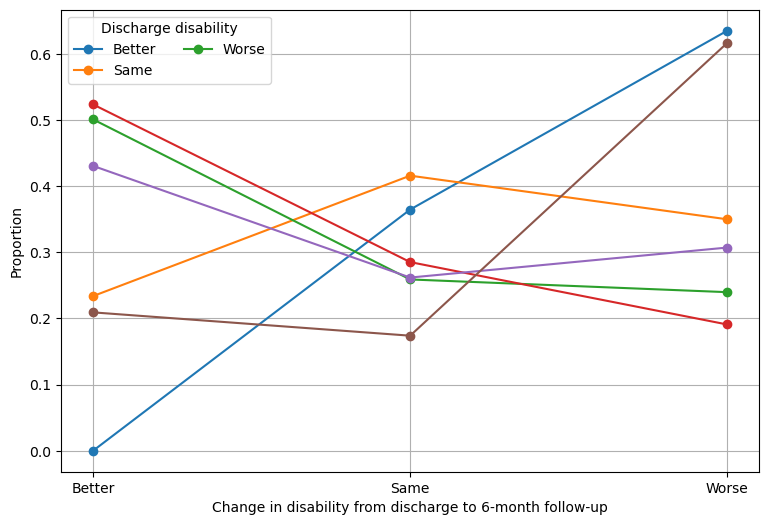

For patients with both scores who had arrived within 4h known onset:


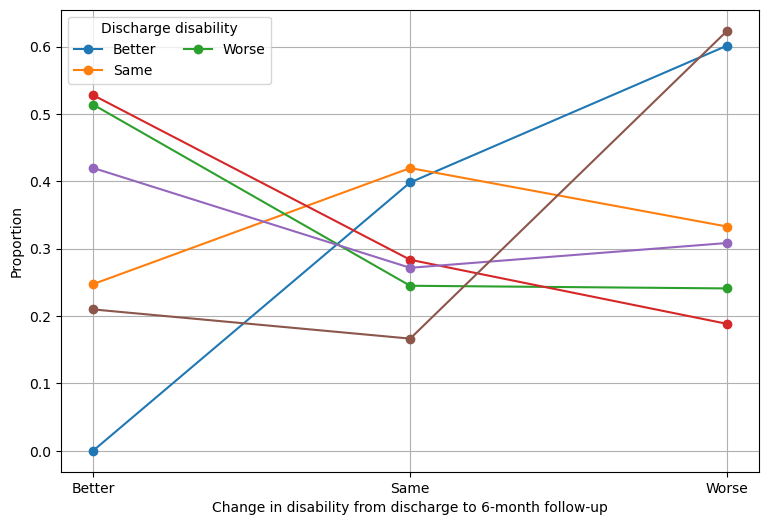

In [10]:
def plot_disability_change(df):
    # Extract individuals with complete data at followup
    mrs_compare = (df[['disability_6_month', 'discharge_disability']]
                   .dropna()
                   .rename(columns={'disability_6_month': 'followup',
                                    'discharge_disability': 'discharge'}))

    # Compare 6 month disability to discharge disability
    mrs_compare['compare'] = np.where(
        mrs_compare['followup'] > mrs_compare['discharge'], 'Worse',
        np.where(mrs_compare['followup'] < mrs_compare['discharge'],
                 'Better', 'Same'))

    # Find proportion better, same or worse - by discharge disability
    mrs_compare_3 = (
        mrs_compare.groupby('discharge')['compare']
        .value_counts(normalize=True)
        .reset_index(name='prop')
        .sort_values(by=['discharge', 'compare'])
        .pivot(index='discharge',
               columns='compare',
               values='prop')
        .fillna(0))

    # Plot those proportions
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(mrs_compare_3.T, marker='o')
    ax.set_xlabel('Change in disability from discharge to 6-month follow-up')
    ax.set_ylabel('Proportion')
    ax.legend(ax.get_lines(), mrs_compare_3.columns, loc='best',
              title='Discharge disability', ncol=2)
    ax.grid()
    plt.show()


print('For all patients with scores at both times:')
plot_disability_change(data_full)
print('For patients with both scores who had arrived within 4h known onset:')
plot_disability_change(data)

For all patients with scores at both times:


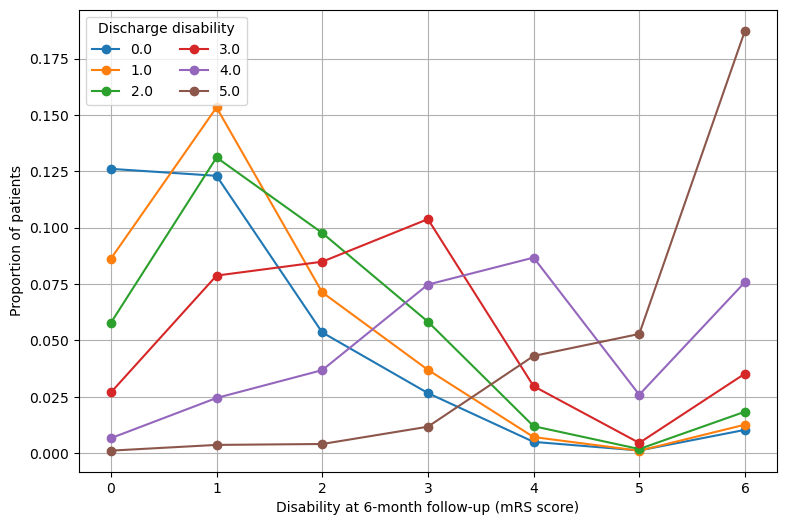

For patients with both scores who had arrived within 4h known onset:


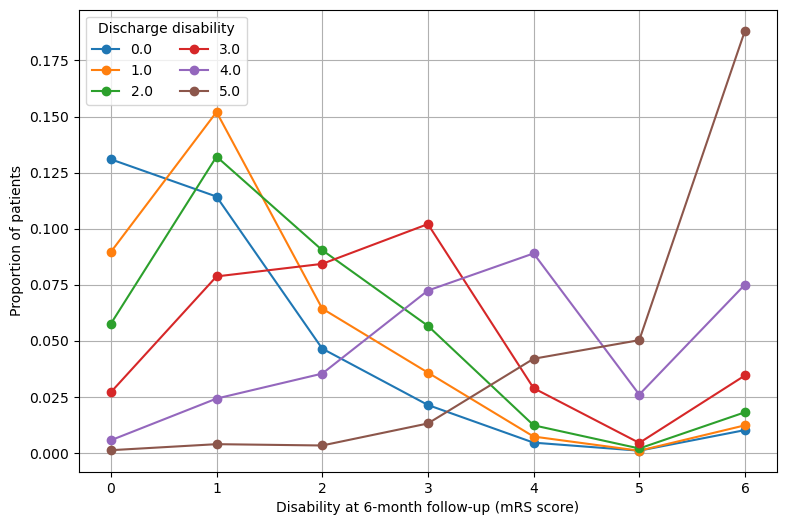

In [11]:
def plot_follow_up_by_discharge(df):
    # Find proportion with each disability at 6 months,
    # grouped by discharge disability
    followup = (df
                .groupby('discharge_disability')['disability_6_month']
                .value_counts(normalize=True, dropna=False)
                .reset_index(name='prop')
                .sort_values(by=['discharge_disability',
                                 'disability_6_month']))

    # Pivot those results so they're suitable for plot
    followup_p = (followup
                  .dropna()
                  .pivot(columns='disability_6_month',
                         index='discharge_disability',
                         values='prop'))

    # Create plot (line plot as easier to see difference in proportions)
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(followup_p.T, marker='o')
    ax.set_xlabel('Disability at 6-month follow-up (mRS score)')
    ax.set_ylabel('Proportion of patients')
    ax.legend(ax.get_lines(), followup_p.columns, loc='best',
              title='Discharge disability', ncol=2)
    ax.grid()
    plt.show()


print('For all patients with scores at both times:')
plot_follow_up_by_discharge(data_full)
print('For patients with both scores who had arrived within 4h known onset:')
plot_follow_up_by_discharge(data)

## Regression

In [12]:
# Extract relevant columns and drop rows with NA
reg_df = data[['prior_disability', 'stroke_severity', 'age',
               'thrombolysis', 'discharge_disability',
               'disability_6_month']].dropna()

# Summarise data that is used in analysis
round(reg_df.describe(), 2)

,prior_disability,stroke_severity,age,thrombolysis,discharge_disability,disability_6_month
count,39167.00,39167.0,39167.00,39167.00,39167.00,39167.00
mean,0.86,7.0,73.48,0.32,2.11,2.21
std,1.28,6.5,12.95,0.47,1.47,1.85
min,0.00,0.0,37.50,0.00,0.00,0.00
25%,0.00,2.0,67.50,0.00,1.00,1.00
50%,0.00,5.0,77.50,0.00,2.00,2.00
75%,1.00,10.0,82.50,1.00,3.00,3.00
max,5.00,42.0,92.50,1.00,5.00,6.00


In [13]:
# Define predictor and response variables
X = reg_df[['prior_disability', 'stroke_severity', 'age',
            'thrombolysis', 'discharge_disability']]
y = reg_df['disability_6_month'] - reg_df['discharge_disability']

# Fit regression model
model = LinearRegression()
model.fit(X, y)

# Display coefficients and intercept
display(pd.DataFrame({'variable': X.columns,
                      'coefficient': model.coef_}))
print(f'Intercept = {model.intercept_}')

,variable,coefficient
0,prior_disability,0.328609
1,stroke_severity,0.050235
2,age,0.014920
3,thrombolysis,-0.284389
4,discharge_disability,-0.513383


Intercept = -0.4542179155606933


,variable,coefficient
0,prior_disability,0.329227
1,stroke_severity,0.051133
2,age,0.015077
3,thrombolysis,-0.279673
4,discharge_disability,-0.514519


Intercept = -0.47
MAE: 1.04
RMSE: 1.38


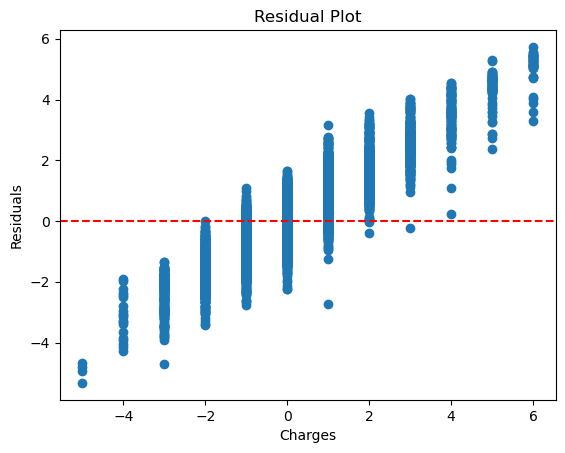

In [14]:
# With train test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# Fit regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Display coefficients and intercept
display(pd.DataFrame({'variable': X_train.columns,
                      'coefficient': model.coef_}))
print(f'Intercept = {model.intercept_:.2f}')

# Test and evaluate model
test_predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

# Create residual plot
residuals = y_test - test_predictions
plt.scatter(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Charges")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()